# Functions and Maps

R is a highly procedural language. This means that most of the time you'll modify data through function calls.

This applies to loops and iteration as well. When encountered with a *do this for all data presented here*-situation, R programmers rarely turn to `for` or `while` loops. Instead, they use `map`- or `apply`-functions.

## Functions

A function is defined into a variable with the assignment operator `<-` and the `function`-statement:

In [230]:
example_function <- function (argument, optional_argument='optional not set') {
    print(argument)
    print(optional_argument)
    return(0)
}

# Do not give an optional argument
example_function('test')
# Give arguments with positional placement
example_function('test2','optional set')
# Give arguments with keywords
example_function(optional_argument='optional_set3',argument='test3')
# Missing an argument returns an error, catch it with try()
print(try(example_function()))

[1] "test"
[1] "optional not set"


[1] 0

[1] "test2"
[1] "optional set"


[1] 0

[1] "test3"
[1] "optional_set3"


[1] 0

[1] "Error in print(argument) : \n  argument \"argument\" is missing, with no default\n"
attr(,"class")
[1] "try-error"
attr(,"condition")
<simpleError in print(argument): argument "argument" is missing, with no default>


Arguments are specified in the function definition. Ones with default values are considered optional. Positional arguments are evaluated from left to right. During function call one can also specify arguments by giving their names.

Output of the function call is returned with a call to the `return`-function. One can also use `invisible` to return the output only if it asked during function call. Returning output is especially important if you want to write a function that works with the Tidyverse pipe. If you haven't specified a `return` or `invisible` statement, the last output of the function is returned as `invisible`.

It is important to know that in R all objects are immutable. This means that if you provide a function with an object, R will copy this object once it knows it will be accessed (lazy evaluation) and any changes you make to this object are not done to the original object unless you assign the result to the original object.

In [231]:
x <- (1:10)

multiply_noreturn <- function (multiplier,inputvector) {
    inputvector <- multiplier * inputvector
}

multiply_return <- function (multiplier,inputvector) {
    inputvector <- multiplier * inputvector
    return(inputvector)
}

multiply_invisible <- function (multiplier,inputvector) {
    inputvector <- multiplier * inputvector
    invisible(inputvector)
}

print('Return always returns output while invisible / no return do not produce output unless asked:')
multiply_noreturn(2,x)
multiply_return(2,x)
multiply_invisible(2,x)

print('x has of course not changed:')
print(x)

print('All functions return the same output when they are saved to variables:')

x2_noreturn<-multiply_noreturn(2,x)
x2_return<-multiply_return(2,x)
x2_invisible<-multiply_invisible(2,x)

print(x2_noreturn)
print(x2_return)
print(x2_invisible)

[1] "Return always returns output while invisible / no return do not produce output unless asked:"


[1]  2  4  6  8 10 12 14 16 18 20

[1] "x has of course not changed:"
 [1]  1  2  3  4  5  6  7  8  9 10
[1] "All functions return the same output when they are saved to variables:"
 [1]  2  4  6  8 10 12 14 16 18 20
 [1]  2  4  6  8 10 12 14 16 18 20
 [1]  2  4  6  8 10 12 14 16 18 20


All R-functions do their work in an environment. If some variable has not been set in that specific environment, it will look to the environment that made the function call. Any change to these variables is made to the environment of the function.

In [232]:
very_secret_key <- 'this is a very secret key indeed' 

peek_at_the_secret_key <- function() {
    print('I know that your secret key is:')
    print(very_secret_key)
}

modify_the_secret_key <- function() {
    very_secret_key <- 'I changed your key!'
}

# This works, function can access global environment
peek_at_the_secret_key()

# This does not work, function will write to its own environment
modify_the_secret_key()

very_secret_key

[1] "I know that your secret key is:"
[1] "this is a very secret key indeed"


[1] "this is a very secret key indeed"

This might give you an idea to use global variables instead of arguments. That is not a good idea. 

This environment lookup is mostly used to allow function `f` to call function `g` or constant `c` from the package where it has been defined.

## Nesting

Lets say we want to store statistics we calculated from `iris`-dataset with our data. Currently this is not possible, as the statistics do not share the same form factor as our original data. To fix this issue lets use `nest` to store the data belonging different species in different `tibble`s ([[nest]](http://tidyr.tidyverse.org/reference/nest.html)).

In [233]:
library(tidyverse)

iris_nested <- as_tibble(iris) %>%
    group_by(Species) %>%
    nest()

print(iris_nested)

# A tibble: 3 x 2
  Species    data             
  <fct>      <list>           
1 setosa     <tibble [50 × 4]>
2 versicolor <tibble [50 × 4]>
3 virginica  <tibble [50 × 4]>


Now the data belonging to each species is stored in the data-variable. Now we cannot, however just use summarize the data as the summary would not be done against the `tibble` stored in the data. Instead we need to define a function that acts on the data itself and use a map that acts on the list on which the data-`tibble`s are stored.

Before we do that let's go through maps.

## Maps

In many cases we want to go through a list one element at a time. In the previous example we have a list of `tibble`s.

On each element we want to run function `iris_statistics` that calculates statistics.

In [234]:
iris_statistics <- function(tbl) {
    return(as_tibble(tbl %>%
        summarize(
            Petal.Length_mean=mean(Petal.Length),
            Petal.Width_mean=mean(Petal.Width),
            Petal.Length_var=var(Petal.Length),
            Petal.Width_var=var(Petal.Width),
            Petal_cor=cor(Petal.Length,Petal.Width)))
    )
}

as_tibble(iris) %>%
    group_by(Species) %>%
    iris_statistics()

Species,Petal.Length_mean,Petal.Width_mean,Petal.Length_var,Petal.Width_var,Petal_cor
setosa,1.462,0.246,0.03015918,0.01110612,0.3316300
versicolor,4.260,1.326,0.22081633,0.03910612,0.7866681
virginica,5.552,2.026,0.30458776,0.07543265,0.3221082


We can see that it produces the same results that we got in the previous chapter.

Let's now create a new variable `statistics` with `mutate` and `map` [[map]](http://purrr.tidyverse.org/reference/map.html).

`map` is provided by the purrr-package. There are variants of it based on the return value of the used function. As our function `iris_statistics` returns a `tibble` for each element, we want to use `map` that creates a list from the outputs.

In [235]:
iris_nested <- iris_nested %>%
    mutate(statistics=map(data,iris_statistics))

print(iris_nested)

# A tibble: 3 x 3
  Species    data              statistics      
  <fct>      <list>            <list>          
1 setosa     <tibble [50 × 4]> <tibble [1 × 5]>
2 versicolor <tibble [50 × 4]> <tibble [1 × 5]>
3 virginica  <tibble [50 × 4]> <tibble [1 × 5]>


Now our statistics are stored in the variable `statistics`. They are not that easy to access, though. Let's use `unnest` to reverse the nesting in the `statistics`-variable.

In [236]:
iris_nested <- iris_nested %>%
    unnest(statistics)

print(iris_nested)

# A tibble: 3 x 7
  Species    data            Petal.Length_me… Petal.Width_mean Petal.Length_var
  <fct>      <list>                     <dbl>            <dbl>            <dbl>
1 setosa     <tibble [50 × …             1.46            0.246           0.0302
2 versicolor <tibble [50 × …             4.26            1.33            0.221 
3 virginica  <tibble [50 × …             5.55            2.03            0.305 
# ... with 2 more variables: Petal.Width_var <dbl>, Petal_cor <dbl>


Now we can e.g. plot the means and variances with bar plot [[errorbar]](https://ggplot2.tidyverse.org/reference/geom_linerange.html).

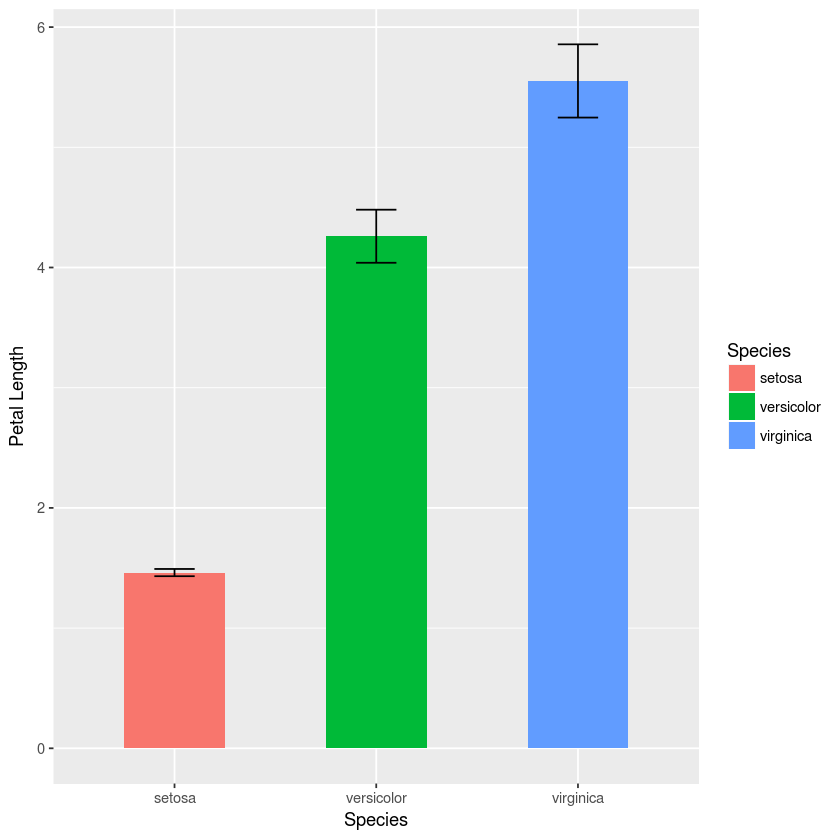

In [237]:
iris_nested %>%
    ggplot(aes(x=Species,y=Petal.Length_mean,fill=Species)) +
    geom_col(width=.5)+
    geom_errorbar(
        aes(ymin=Petal.Length_mean-Petal.Length_var,ymax=Petal.Length_mean+Petal.Length_var),
        width=0.2) +
    ylab('Petal Length')

# Exercise time:

Do this exercise to `storms`-dataset initialized below that is a subset of NOAA Atlantic hurricane database [[storms]]](http://dplyr.tidyverse.org/reference/storms.html).

1. Group the dataset based on `name`. Nest the data.
2. Use map to calculate the minimum pressure, maximum wind speed and maximum category for each storm. Store these to the object. Unwind them into variables.
3. Plot a scatterplot with x-axis showing minimum pressure, y-axis showing maximum wind speed and colour showing maximum category.

In [238]:
str(storms)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	10010 obs. of  13 variables:
 $ name       : chr  "Amy" "Amy" "Amy" "Amy" ...
 $ year       : num  1975 1975 1975 1975 1975 ...
 $ month      : num  6 6 6 6 6 6 6 6 6 6 ...
 $ day        : int  27 27 27 27 28 28 28 28 29 29 ...
 $ hour       : num  0 6 12 18 0 6 12 18 0 6 ...
 $ lat        : num  27.5 28.5 29.5 30.5 31.5 32.4 33.3 34 34.4 34 ...
 $ long       : num  -79 -79 -79 -79 -78.8 -78.7 -78 -77 -75.8 -74.8 ...
 $ status     : chr  "tropical depression" "tropical depression" "tropical depression" "tropical depression" ...
 $ category   : Ord.factor w/ 7 levels "-1"<"0"<"1"<"2"<..: 1 1 1 1 1 1 1 1 2 2 ...
 $ wind       : int  25 25 25 25 25 25 25 30 35 40 ...
 $ pressure   : int  1013 1013 1013 1013 1012 1012 1011 1006 1004 1002 ...
 $ ts_diameter: num  NA NA NA NA NA NA NA NA NA NA ...
 $ hu_diameter: num  NA NA NA NA NA NA NA NA NA NA ...
